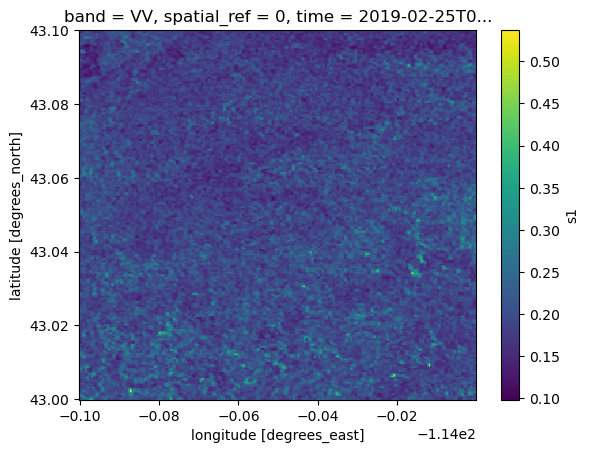

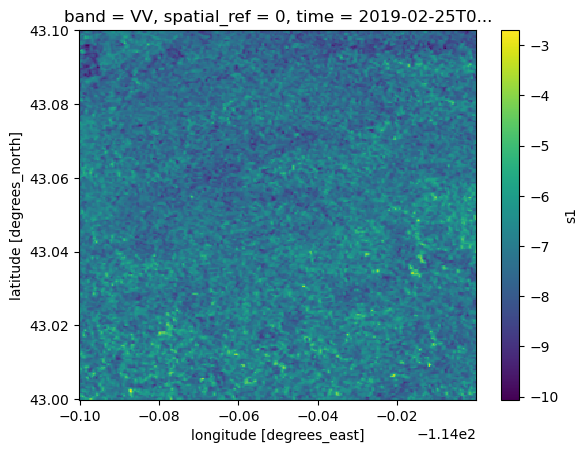

In [80]:
# standard imports
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import pickle

with open('2_img_test.pkl', 'rb') as f:
    ds = pickle.load(f)


# add module to path so python can import it. This is the directory with
# the __init__.py file in it to let python know this is a module.
import sys
sys.path.append('/Users/w76m851/github_workspace/spicy-snow/spicy_snow')

# import the function to test
from processing.s1_preprocessing import s1_amp_to_dB


# plot first time slice and VV band to see initial
ds['s1'].isel(time=0).sel(band='VV').plot()
plt.show()

# snag the original time slice to compare afterwards
amp = ds['s1'].isel(time=0).sel(band='VV').values.ravel()
amp = amp[amp != 0]

# run your newly written function over the dataset and capture returning dataset
s1_amp_to_dB(ds)

# plot first time slice and VV band to see dB change

ds['s1'].isel(time=0).sel(band='VV').plot()
plt.show()

# grab the first time slice VV
dB = ds['s1'].isel(time=0).sel(band='VV').values.ravel()
dB = dB[np.isfinite(dB)]

# assert the conversion was succesful
assert np.allclose(dB, 10 * np.log10(amp))

In [94]:
def s1_clip_outliers(dataset: xr.Dataset, inplace: bool=False) -> xr.Dataset:
    """
    Remove s1 image outliers by masking pixels 3 dB above 90th percentile or
    3 dB before the 10th percentile. (-35 -> 15 dB for VV) and (-40 -> 10 for VH
    in HL's code - line # 291)

    Args:
    dataset: Xarray Dataset of sentinel images to clip outliers
    inplace: boolean flag to modify original Dataset or return a new Dataset

    Returns:
    dataset: Xarray Dataset of sentinel images with masked outliers
    """
    # Check inplace flag
    if inplace:
        ds = dataset
        rtrn = False
    else:
        ds = dataset.copy(deep=True)
        rtrn = True

    # Calculate time series 10th and 90th percentile 
    # Threshold vals 3 dB above/below percentiles
    for band in ['VV','VH']:
        data = ds['s1'].sel(band=band)
        vals = ds['s1'].sel(band=band).values.flatten()
        vals_valid = vals[~np.isnan(vals)]
        thresh_lo = np.percentile(vals_valid, 10) - 3
        thresh_hi = np.percentile(vals_valid, 90) + 3
        # Mask using percentile thresholds
        data_masked = data.where((data > thresh_lo) & (data < thresh_hi))
        ds['s1'].loc[dict(band = band)] = data_masked

    if rtrn:
        return ds


In [95]:
test = s1_clip_outliers(ds, inplace=False)

for band in ['VV','VH']:
    print(f'{band} nans before:', sum(np.isnan(ds['s1'].sel(band=band).data.flatten())))
    print(f'{band} nans after:', sum(np.isnan(test['s1'].sel(band=band).data.flatten())))


VV nans before: 292
VV nans after: 292
VH nans before: 292
VH nans after: 319


In [79]:
ds_copy = ds

ds_copy['s1'].loc[dict(band = 'VV')] = ds['s1'].sel(band='VV').where((ds['s1'].sel(band='VV') > -7.7) & (ds['s1'].sel(band='VV') < -6.8))
# ds_copy['s1'].loc[dict(band = 'VV')].data.shape
# ds['s1'].sel(band='VV').where((ds['s1'].sel(band='VV') > -7.7) & (ds['s1'].sel(band='VV') < -6.8)).data.shape
# ds_copy['s1']
ds['s1']


<xarray.DataArray 's1' (time: 3, band: 3, y: 292, x: 292)>
array([[[[ -7.6284738 ,          nan,          nan, ...,  -7.025305  ,
                   nan,  -7.3496466 ],
         [         nan,          nan,          nan, ...,  -7.6131053 ,
                   nan,  -7.222548  ],
         [ -7.558696  ,  -7.2649107 ,  -6.9925075 , ...,          nan,
                   nan,  -7.425576  ],
         ...,
         [         nan,          nan,          nan, ...,  -7.3554015 ,
           -7.100643  ,  -6.960619  ],
         [ -7.0812283 ,          nan,          nan, ...,  -7.3297825 ,
           -7.1872425 ,  -7.426963  ],
         [ -7.0221567 ,          nan,          nan, ...,          nan,
                   nan,  -7.618761  ]],

        [[-12.767912  , -12.927839  , -12.037563  , ..., -13.392114  ,
          -12.404312  , -12.447916  ],
         [-11.821842  , -12.206463  , -11.90354   , ..., -13.726706  ,
          -13.229044  , -13.153338  ],
         [-11.074309  , -11.21479   , -11.249525  , ..., -13.022894  ,
          -13.169026  , -13.244328  ],
...
         [         nan, -10.203515  ,  -9.860106  , ..., -10.629898  ,
          -11.004654  , -10.624718  ],
         [         nan, -10.1134815 ,  -9.909009  , ..., -11.115979  ,
          -11.668489  , -10.740044  ],
         [         nan, -10.0654745 , -10.247007  , ..., -11.112057  ,
          -11.513412  , -10.8675375 ]],

        [[         nan,   0.63582045,   0.65218943, ...,   0.5594206 ,
            0.5594206 ,   0.5748615 ],
         [         nan,   0.6144743 ,   0.519464  , ...,   0.61278045,
            0.58462036,   0.57076627],
         [         nan,   0.61265856,   0.61265856, ...,   0.61406326,
            0.6366995 ,   0.62741804],
         ...,
         [         nan,   0.49735326,   0.47026423, ...,   0.61605585,
            0.616655  ,   0.6030796 ],
         [         nan,   0.5348751 ,   0.5849828 , ...,   0.63450307,
            0.6245441 ,   0.59943455],
         [         nan,   0.63454956,   0.6620331 , ...,   0.59552217,
            0.62419665,   0.6236007 ]]]], dtype=float32)
Coordinates:
  * x               (x) float64 -114.1 -114.1 -114.1 ... -114.0 -114.0 -114.0
  * y               (y) float64 43.1 43.1 43.1 43.1 43.1 ... 43.0 43.0 43.0 43.0
  * band            (band) <U3 'VV' 'VH' 'inc'
    spatial_ref     int64 0
  * time            (time) datetime64[ns] 2019-02-25T01:27:19 ... 2019-03-21T...
    flight_dir      (time) <U9 'ascending' 'ascending' 'ascending'
    platform        (time) <U3 'S1B' 'S1B' 'S1B'
    relative_orbit  (time) int64 20 20 20
    projection      int64 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0.0

In [47]:
test_ds = xr.Dataset(data_vars={'ims':ds['ims'], 'fcf':ds['fcf']})
test_ds.assign(s1=test)
test_ds

<xarray.Dataset>
Dimensions:         (x: 292, y: 292, time: 3)
Coordinates:
  * x               (x) float64 -114.1 -114.1 -114.1 ... -114.0 -114.0 -114.0
  * y               (y) float64 43.1 43.1 43.1 43.1 43.1 ... 43.0 43.0 43.0 43.0
    spatial_ref     int64 0
  * time            (time) datetime64[ns] 2019-02-25T01:27:19 ... 2019-03-21T...
    flight_dir      (time) <U9 'ascending' 'ascending' 'ascending'
    platform        (time) <U3 'S1B' 'S1B' 'S1B'
    relative_orbit  (time) int64 20 20 20
    projection      int64 0
Data variables:
    ims             (time, y, x) int8 4 4 4 4 4 4 4 4 4 4 ... 2 2 2 2 2 2 2 2 2
    fcf             (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [56]:
ds['s1'].band

<xarray.DataArray 'band' (band: 3)>
array(['VV', 'VH', 'inc'], dtype='<U3')
Coordinates:
  * band         (band) <U3 'VV' 'VH' 'inc'
    spatial_ref  int64 0
    projection   int64 0